In [1]:
import numpy as np
import math, os
import matplotlib.pyplot as plt
import pandas as pd

# CRAFT imports
from craft_text_detector import load_craftnet_model, load_refinenet_model, empty_cuda_cache
from craft_predict_batch import get_prediction_batch

# Pre and post processing imports
from utils import read_log
from word_matching import process_words, match_batch
from image_processing import images_to_rects, save_crops

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


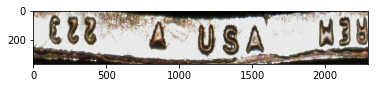

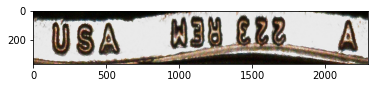

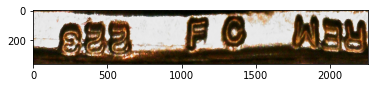

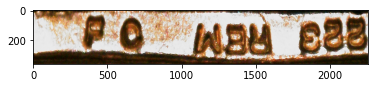

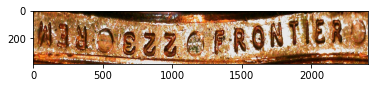

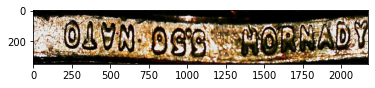

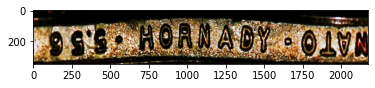

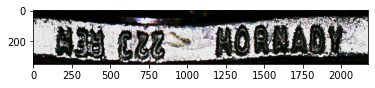

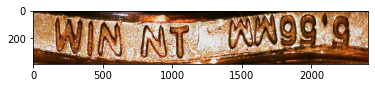

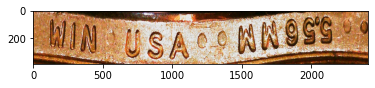

In [2]:
test_filenames = os.listdir("data/test_images")
rects = images_to_rects(test_filenames, foldername="data/test_images", adjust=True, downsample=False, plot=True)

# CRAFT model for text region detection

In [3]:
# Load models
refine_net = load_refinenet_model(cuda=False)
craft_net = load_craftnet_model(cuda=False)

In [4]:
# Perform batch prediction. Note this will take a while to process the whole batch - about 5s/image. CRAFT model doesn't seem to get faster inference times/image for bigger batches...
# Print prediction_result["times"] to see exact inference time.
# This function has been modified from original code to accept batches
prediction_result = get_prediction_batch(
    images=rects,
    craft_net=craft_net,
    refine_net=refine_net,
    text_threshold=0.7,
    link_threshold=0.7,#0.4,
    low_text=0.4,
    cuda=False,
    long_size=1280
)
empty_cuda_cache() # unload models from gpu

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
save_crops(rects, prediction_result)

# DRTB models for text recognition

Note this is pretty slow because it requires file reading and loading the models. Speed this up by reading directly from CRAFT output, and by moving model load to beginning.

In [6]:
# Perform DRTB inference. Inference time/image = total time / images in batch, about 1s/image for batch_size=10.
# Print output to see exact timings.
# demo_func.py has been modified to give cleaner output log
!set CUDA_VISIBLE_DEVICES=0
output = !python deep-text-recognition-benchmark/demo_func.py \
--Transformation None --FeatureExtraction ResNet --SequenceModeling None --Prediction CTC \
--image_folder temp_crops/ \
--saved_model deep-text-recognition-benchmark/None-ResNet-None-CTC.pth

In [7]:
# Read output
lines = read_log("log_demo_result.txt")

In [8]:
# Obtain bag of words from DRTB raw output
words_batch = process_words(lines, len(test_filenames))

In [9]:
# Desired classes. Anything not falling in these will be OOD.
CLASSES = ["winusa556mm", "winnt556mm", "hornadynato556", "hornady223mm", "frontier223rem", "fc223rem", "ausa223rem"]

In [10]:
# Match bag of words with classes using fuzzy matching. This is fast.
preds, confs = match_batch(words_batch, CLASSES, conf_thresh=60, reject_word="REJECT")

In [11]:
pd.DataFrame([test_filenames, preds, confs])

,0,1,2,3,4,5,6,7,8,9
0,AUSA_1.jpg,AUSA_2.jpg,FCPlain_1.jpg,FC_Plain_2.jpg,Frontier_1.jpg,Hornady556_1.jpg,Hornady556_2.jpg,Hornady_1.jpg,WinNT556_1.jpg,WinUSA556_1.jpg
1,REJECT,REJECT,REJECT,REJECT,frontier223rem,hornadynato556,hornadynato556,REJECT,winnt556mm,winusa556mm
2,50,53,0,60,62,80,62,55,84,100
